# Data Analysis

In this notebook we study the error in our numerical method as well as preform various sanity checks on the results. These are:
1. Ploting the RMSv
2. Ploting the Error in Energy Conservation as a function of timestep size
3. Generating contour plots at various timesteps to compare with the results of Schaer and Wernli's paper for the initial condition of an isolated Semi-Geostrophic Cyclone. 

### Import the needed packages 

In [1]:
import numpy as np
import time
from solvers import mainHeun as Heun
from solvers import mainRK4 as RK4
from solvers import mainAB2 as AB2
from solvers import mainCN as CN
import erroranalysis as err
import auxfunctions as aux
import matplotlib.pyplot as plt
import random

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


### Load in the Data

In [2]:
ZRef, CRef, WRef, MRef, TCRef = aux.load_data('./PaperData/RK4_SG_data_10-3_32_1hr.msgpack')
box = [-3.66, -1.75, 0, 3.66, 1.75, 0.45]

In [3]:
Z, C, W, M, TC = aux.load_data('./PaperData/RK4_SG_data_10-3_28_1hr.msgpack')

## Error Analysis

Here we investigate the Weighted Euclidian Error and the Sinkhorn loss. These are done by comparison to a "high-resolution" simulation. 

### Check the Weighted Euclidian Error

In [ ]:
for comptime in [12.3974, 24.7947, 37.2351, 52]:    
    euclid_error = err.Weighted_Euclidian_Error(Z, ZRef, MRef, 52, comptime, box)
    print(comptime, euclid_error)

### Check the Wasserstein Distance

In [10]:
for comptime in [12.3974, 24.7947, 37.2351, 52]:
    WD = err.Wasserstein_Distance(Z, M, ZRef, MRef, 52, comptime, box)
    print(WD)

0.004508895827354824
0.004509112296849696
0.004508763141703745
0.004508762114566284


## Next we have our coding sanity checks

### Check the RMSv

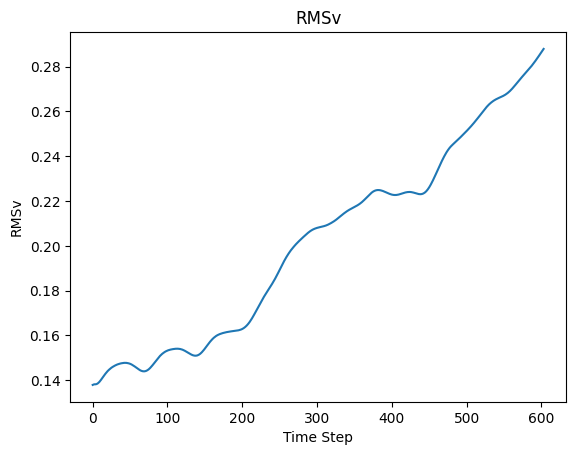

In [6]:
RMSv = err.Root_Mean_Squared_Velocity(ZRef, CRef, 'Zonal')

# Create a line plot
plt.plot(RMSv)

# Add labels and title
plt.xlabel('Time Step')
plt.ylabel('RMSv')
plt.title('RMSv')

plt.show()

### Checking that the Transport Cost is Conserved

In [ ]:
# Define dictionary for maping files
solver_name_map = {
    AB2: 'AB2',
    Heun: 'Heun',
    RK4: 'RK4',
    CN: 'CN'
}

# Define the parameters of the system
box = [-2, -1, 0, 2, 1, 0.5] # List or tuple defining domain [xmin, ymin, zmin, xmax, ymax, zmax]
per_tol = 1e-3 # Percent tolerance
per_x = True # Set the periodicity of X
per_y = False # Set the periodicity of Y
per_z = False # Set the periodicity of Z
tf = 26 # Final time
Ndt = np.linspace(20, 2000, 20, endpoint=True) # Number of timesteps
N = 10 # Number of seeds
Z = np.array([(random.uniform(box[0], box[3]),
               random.uniform(box[1], box[4]),
               random.uniform(box[2], box[5])) for _ in range(N)]) # Place the seeds randomly

# Function to run a solver test and compute metrics
def run_test(solver, box, Z, per_tol, tf, Ndt, per_x, per_y, per_z, debug=False):
    """
    Runs a specific solver and returns conservation error and runtime.

    Parameters:
    - solver: The solver function to run.
    - box, Z, per_tol, tf, Ndt, per_x, per_y, per_z: Parameters for the solver.
    - debug: Whether to run the solver in debug mode.

    Returns:
    - Maximum conservation error and runtime for the solver.
    """
    start_time = time.time()
    solver.SG_solver(box, Z, per_tol, tf, int(Ndt), per_x, per_y, per_z, debug=debug)
    runtime = time.time() - start_time
    
    solver_name = solver_name_map[solver]
    seeds, C, _, _, TC = aux.load_data(f'./data/{solver_name}_SG_data.msgpack')
    _, _, _, _, E, _ = aux.get_properties(seeds, C, TC)
    meanEnergy = np.mean(E)
    ConservationError = np.abs((E - meanEnergy) / meanEnergy)

    return max(ConservationError), runtime

# Main loop
solvers = [AB2, Heun, RK4, CN] # Assuming AB2, Heun, RK4, DOPRI are defined elsewhere
data = {solver.__name__: [] for solver in solvers}

for i in Ndt:
    for solver in solvers:
        error, runtime = run_test(solver, box, Z, per_tol, tf, i, per_x, per_y, per_z)
        data[solver.__name__].append((error, runtime))
    print(f"Completed iteration with Ndt={i}")

In [ ]:
# Calculate initial time step sizes for the x-axis
initial_time_steps = tf / Ndt

# Function to plot data for a specific solver
def plot_solver_data(ax1, ax2, data, initial_time_steps, label, color):
    max_errors = [d[0] for d in data]  # Extract max conservation errors
    runtimes = [d[1] for d in data]  # Extract runtimes

    ax1.plot(initial_time_steps, max_errors, label=f"{label} Max Error", color=color)
    ax2.plot(initial_time_steps, runtimes, label=f"{label} Runtime", color=color, linestyle="--")

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

colors = ['blue', 'red', 'green', 'black']
labels = ['mainAB2', 'mainHeun', 'mainRK4', 'mainCN']

# Iterate through each solver and plot
for solver, color in zip(labels, colors):
    plot_solver_data(ax1, ax2, data[solver], initial_time_steps, solver, color)

# Labeling the axes
ax1.set_xlabel('Initial Time Step')
ax1.set_ylabel('Max Conservation Error', color='tab:blue')
ax2.set_ylabel('Runtime (sec)', color='tab:red')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.title('Comparison of ODE Solvers: Conservation Error and Runtime')
plt.show()

### Contour plots of the temperature

In [ ]:
# Load in a package to preform a nearest neighbour search
from scipy.spatial import cKDTree

# Select the timestep you want to plot (e.g., 0 for the first timestep)
a, b, c = 3.66, 1.75, 0.45 # Pull in the dimensions of the fundamental domain
selected_timestep = 1114  # Adjust this as needed
fixed_z = c # Set whether we are ploting the temperature on the surface or on the lid

# First we compute the temperature and zip it to the corresponding centroid
_, _, _, T, _, _ = aux.Properties(Z, C, TC)
T_selected = T[selected_timestep, :, np.newaxis]  # T for selected timestep
C_selected = C[selected_timestep]  # Positions for selected timestep
CT_selected = np.concatenate((C_selected, T_selected), axis=1)  # Combine selected positions and temperatures

# Set the shift value to ensure that the copies lie in [-2a,-a] and [a,2a]
x_shift = 1.5 * a 
C_rs_selected = CT_selected.copy()
C_ls_selected = CT_selected.copy()
C_rs_selected[:, 0] += x_shift
C_ls_selected[:, 0] -= x_shift

# Combine the original and the two shifted centroid positions
combined_positions = np.vstack((CT_selected, C_rs_selected, C_ls_selected))

# Next we generate a grid containing all of the points on the surface or the lid for our contour plot. 

# Grid dimensions in x and y directions
num_points_x = 1000  # Number of points in x
num_points_y = 500   # Number of points in y

# Generate grid points for x and y
x = np.linspace(-a, a, num_points_x)
y = np.linspace(-b, b, num_points_y)

# Create meshgrid for x and y
x_grid, y_grid = np.meshgrid(x, y)

# Flatten the x and y grid arrays
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Set the z coordinate
z_flat = np.full_like(x_flat, fixed_z)  # Create an array filled with the fixed z value

# Combine x, y, and z into a Mx3 matrix
sample_points = np.vstack((x_flat, y_flat, z_flat)).T

# Nearest neighbor search for the selected timestep
tree = cKDTree(combined_positions[:, :3])  # Use positions only
distances, indices = tree.query(sample_points, k=1)
nearest_temperatures = combined_positions[indices, 3]

# Prepare sample points with temperature for plotting
sample_points_with_temp = np.hstack((sample_points, nearest_temperatures[:, np.newaxis]))
xy_temp = sample_points_with_temp[:, [0, 1, 3]]

# Reshaping and plotting as before
temperatures_grid = xy_temp[:, 2].reshape((num_points_y, num_points_x))
x_unique = np.unique(xy_temp[:, 0])
y_unique = np.unique(xy_temp[:, 1])

plt.figure(figsize=(8, 6))
cp = plt.contourf(x_unique, y_unique, temperatures_grid, cmap='coolwarm', levels=20)
plt.colorbar(cp)
plt.title(f'Temperature Contour Plot at Timestep {selected_timestep}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()